## Importing Libraries

In [ ]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaaa
import matplotlib.image as mpimg
import random
import cv2
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense, Conv2D

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Exploratory Data Analysis and Preprocessing

In [ ]:
data_path = "./udacity/simulator-windows-64/data/driving_log.csv"
data_dir_path = "/content/drive/MyDrive/udacity_car_data/data"
data_dir_path = "/content/drive/MyDrive/udacity_car_data/data_10_05_2024"
columns = ['center' , 'left' , 'right' , 'steering' , 'throttle' , 'isReverse' , 'speed']
data = pd.read_csv(os.path.join(data_dir_path , "driving_log.csv") , names = columns)

#### Over here , steering angle 0 will get a high bias as we have mostly driven on a straight road . Training our model on the raw data will create high bias towards it . Lets trim the dataset by randomly choosing 400 maximum points per bin for the dataset and making it somewhat like a normal distribution and not biasing the prediction . Looking at throttle , isReverse and speed data distribution , it is inferred that it stays mostly constant . So , not much advantage is gained by training on that .

<BarContainer object of 100 artists>

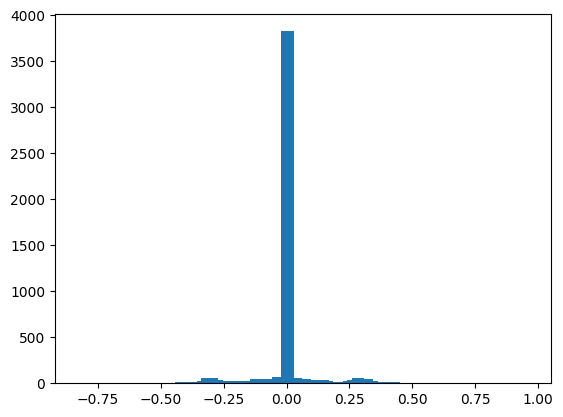

In [ ]:
num_bins = 100
hist , bins = np.histogram(data['steering'] , num_bins)
center = (bins[:-1] + bins[1:]) * 0.5
plt.bar(center , hist , width = 0.05)

In [ ]:
samples_per_bin = 200
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)

print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))

removed: 3625
remaining: 1725


<BarContainer object of 25 artists>

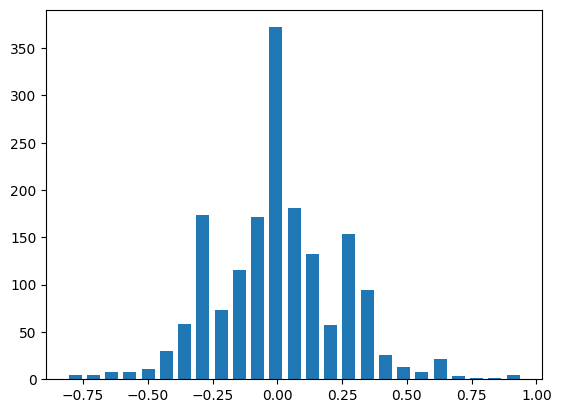

In [ ]:
num_bins = 25
hist , bins = np.histogram(data['steering'] , num_bins)
center = (bins[:-1] + bins[1:]) * 0.5
plt.bar(center , hist , width = 0.05)

#### Finally saving our processed data

In [ ]:
data.to_csv(os.path.join(data_dir_path , "processed_log.csv") , index = False)

## Train Test Split

In [ ]:
data = pd.read_csv(os.path.join(data_dir_path , "processed_log.csv"))
data.shape

(1460, 7)

In [ ]:
# This function loads all the image paths and its corresponding steering angles and returns the two numpy arrays .

def load_img_steering_mapping(data_path , df):
    image_path = []
    steering = []
    for i in range(len(data)):
        row = data.iloc[i]
        #center image append
        image_path.append(row[0].strip())
        steering.append(float(row[3]))
        #left image append
        image_path.append(row[1].strip())
        steering.append(float(row[3])+0.15)
        #right image append
        image_path.append(row[2].strip())
        steering.append(float(row[3])-0.15)
    return np.asarray(image_path) , np.asarray(steering)

In [ ]:
img_paths , steering_angles = load_img_steering_mapping("udacity/simulator-windows-64/data/IMG/" , data)
print(len(img_paths) , len(steering_angles))

5175 5175


C:\Users\Tejas\AppData\Local\Temp\ipykernel_8928\1963381816.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  image_path.append(row[0].strip())
C:\Users\Tejas\AppData\Local\Temp\ipykernel_8928\1963381816.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  steering.append(float(row[3]))
C:\Users\Tejas\AppData\Local\Temp\ipykernel_8928\1963381816.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  image_path.append(row[1].strip())

In [ ]:
x_train , x_test , y_train , y_test = train_test_split(img_paths , steering_angles , test_size= 0.2 , shuffle = True)
print(len(x_train) , len(x_test))
print(len(y_train) , len(y_test))

4140 1035
4140 1035


Text(0.5, 0.98, 'Validating both distributions to be similar')

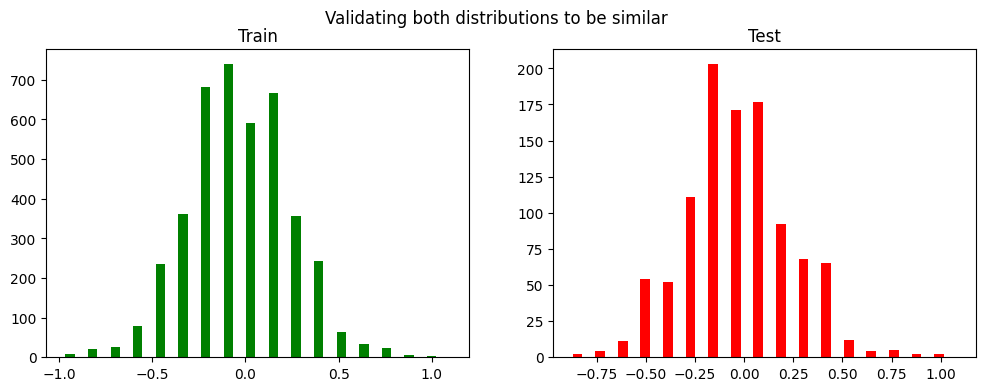

In [ ]:
fig , axes = plt.subplots(1 , 2 , figsize = (12,4))
axes[0].hist(y_train , bins = 17 , width = 0.05 , color = 'green')
axes[0].set_title("Train")
axes[1].hist(y_test , bins = 17 , width = 0.05 , color = 'red')
axes[1].set_title("Test")
fig.suptitle("Validating both distributions to be similar")

In [ ]:
# Ensuring all the elements are in required format .

for x in img_paths :
    if not os.path.exists(x):
        print("error")
        break
print("All paths are strings")

if all(isinstance(x, float) for x in steering_angles):
    print("All elements are floats.")
else:
    print("Not all elements are floats.")

All paths are strings
All elements are floats.


## Loading data processed locally

In [ ]:
x = np.load("/content/drive/MyDrive/udacity_car_data/data_10_05_2024/images.npy")
y = np.load("/content/drive/MyDrive/udacity_car_data/data_10_05_2024/steering_angles.npy")

In [ ]:
print(x.shape , y.shape)

(4380, 160, 320, 3) (4380,)


In [ ]:
x_train , x_test , y_train , y_test = train_test_split(x , y , test_size = 0.2 , shuffle = True)
print(x_train.shape , x_test.shape)
print(y_train.shape , y_test.shape)

(3504, 160, 320, 3) (876, 160, 320, 3)
(3504,) (876,)


In [ ]:
random_index = random.randint(0 , len(x_train)-1)
sample_img = x_train[random_index]
sample_steer = y_train[random_index]

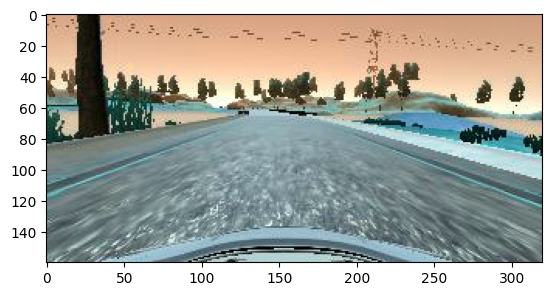

In [ ]:
plt.imshow(sample_img)

##  Data Augmentation

In [ ]:
def load_image(image_path):
    # Over here it was returning as tuple and something string .
    # Typecasting was necessary and was debugged.
    # But our data augmentation techniques required numpy array with floats .
    # Finally using opencv library for the entire data augmentation
    return cv2.imread(image_path , cv2.IMREAD_COLOR)

def zoom(image):
  zoom = iaaa.Affine(scale=(1, 1.7))
  image = zoom.augment_image(image)
  return image

def pan(image):
    pan = iaaa.Affine(translate_percent={"x" : (-0.1,0.1) , "y" : (-0.1 , 0.1)})
    image = pan.augment_image(image)
    return image


def random_brightness_change(image):
    return cv2.convertScaleAbs(image, alpha=random.uniform(0.5,1.5), beta=10)

# def flip(image , steering):
#     image  = iaaa.Fliplr(1.0)
#     return image , -steering

def flip(image, steering):
    # Create an augmenter for horizontal flipping with 100% probability
    # flipper = iaaa.Fliplr(1.0)

    # Apply the flip augmentation to the image
    # flipped_image = flipper.augment_image(image)

    # Return the flipped image and negated steering angle
    return cv2.flip(image , 1), -steering

def random_augment(image , steering_angle):
    if np.random.rand()<0.5:
        image = random_brightness_change(image)
        # print("bright")

    if np.random.rand()<0.5:
        image = pan(image)
        # print("panned")

    if np.random.rand()<0.5:
        image = zoom(image)
        # print("zoomed"/)

    if np.random.rand()<0.5:
        image = flip(image , steering_angle)[0]
        steering_angle = -steering_angle
        # print("flipped")

    return image , steering_angle

In [ ]:
print(type(zoom(sample_img)))
print(type(random_brightness_change(sample_img)))
print(type(pan(sample_img)))
print(type(flip(sample_img , 1)[0]))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


sample steer -0.0375726
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


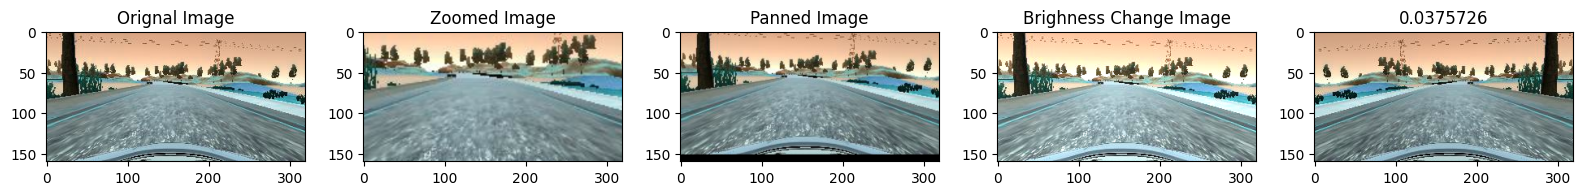

In [ ]:
orignal = sample_img
zoomed_image = zoom(orignal)
panned_image = pan(orignal)
random_brightness_image = random_brightness_change(orignal)
flipped_image , steering = flip(orignal , sample_steer)

fig , axes = plt.subplots(1 , 5 , figsize = (16,12))
fig.tight_layout()
print("sample steer" , sample_steer)


axes[0].imshow(orignal)
axes[0].set_title("Orignal Image")
print(type(orignal))

axes[1].imshow(zoomed_image)
axes[1].set_title("Zoomed Image")
print(type(zoomed_image))

axes[2].imshow(panned_image)
axes[2].set_title("Panned Image")
print(type(panned_image))

axes[3].imshow(random_brightness_image)
axes[3].set_title("Brighness Change Image")
print(type(random_brightness_image))

axes[4].imshow(flipped_image)
axes[4].set_title(f"{steering}")
print(type(flipped_image))


## Image Preprocessing for the  Model

In [ ]:
def img_preprocess(img):
    img = img[50:150 , :] # Just cropping the image
    img = cv2.cvtColor(img , cv2.COLOR_RGB2YUV) # For the nvidia model color scheme
    img = cv2.GaussianBlur(img , (3,3) , 0) # Eliminating noise
    img = cv2.resize(img , (200,66)) # Resizing for the model parameters
    img = img/255 # Normalizing
    return img

Text(0.5, 1.0, '(66, 200, 3)')

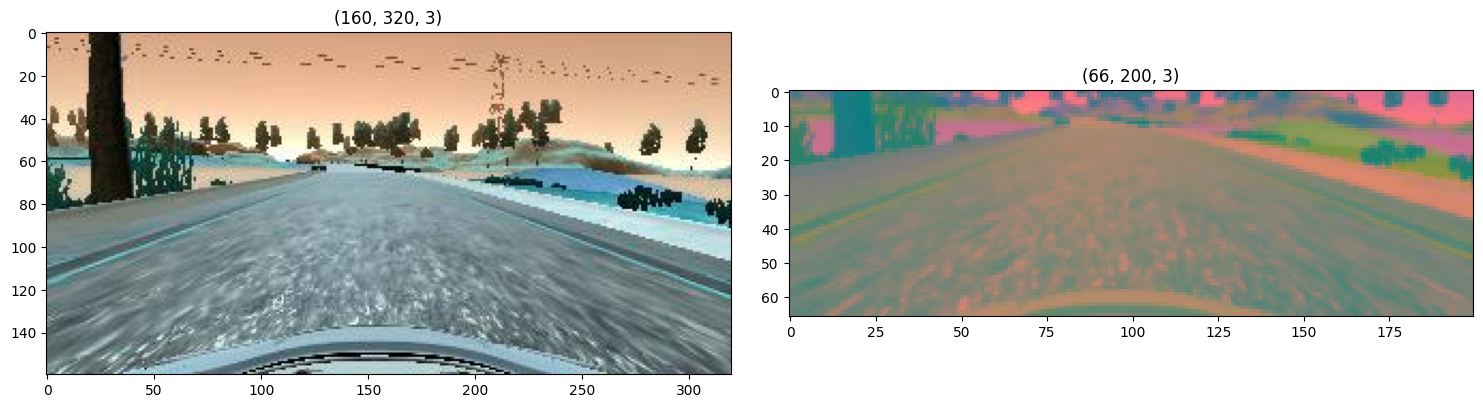

In [ ]:
orignal = sample_img
preprocessed = img_preprocess(orignal)

fig , axes = plt.subplots(1 , 2 , figsize = (15,10))
fig.tight_layout()
axes[0].imshow(orignal)
axes[0].set_title(orignal.shape)
axes[1].imshow(preprocessed)
axes[1].set_title(preprocessed.shape)


## Batch Generation

In [ ]:

def batch_generator(image_paths, steering_ang, batch_size, istraining):

  while True:
    batch_img = []
    batch_steering = []

    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)

      if istraining:
        im , steering = random_augment(x_train[random_index] , y_train[random_index])

      else:
        im = x_test[random_index]
        steering = y_test[random_index]

      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering))

<class 'numpy.ndarray'>


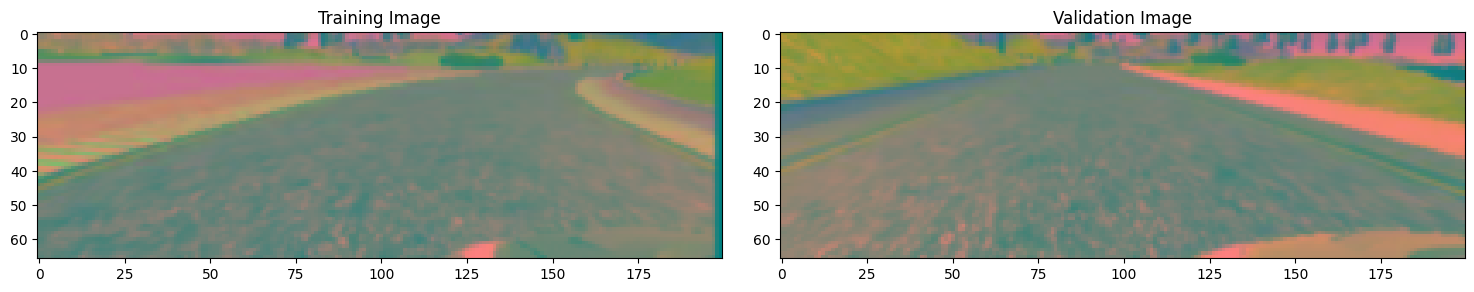

In [ ]:
x_train_gen, y_train_gen = next(batch_generator(x_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(x_test, y_test, 1, 0))

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')

axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image')

print(type(x_train_gen[0]))


#### Preprocessing the whole data

## Architecture of Neural Network

In [ ]:
def self_driving_model():
    model = Sequential()

    # Convolutional Neural Network
    model.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation='elu'))
    model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu'))
    model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu'))
    model.add(Conv2D(64, (5, 5), activation='elu'))
    model.add(Dropout(0.5))

    # Dense Neural Network
    model.add(Flatten())
    model.add(Dense(100, activation = 'elu'))
    model.add(Dropout(0.5))
    model.add(Dense(50, activation = 'elu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation = 'elu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(loss='mse', optimizer=optimizer)
    return model

model = self_driving_model()

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss='mse', optimizer=optimizer)

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 31, 98, 24)        1824      
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 22, 48)         43248     
                                                                 
 conv2d_3 (Conv2D)           (None, 1, 18, 64)         76864     
                                                                 
 dropout (Dropout)           (None, 1, 18, 64)         0         
                                                                 
 flatten (Flatten)           (None, 1152)              0         
                                                                 
 dense (Dense)               (None, 100)               1

## Training

In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
!pip install pyautogui

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 1.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.2/171.2 kB 9.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.8/132.8 kB 13.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for pyautogui: filename=PyAutoGUI-0.9.54-py3-none-any.whl size=37577 sha256=438e8311cb31f9e1004c9db9f3619831a3845ba0d39b8218bfa20

In [ ]:
# Javascript code to keep colab running ...

function ClickConnect(){
  console.log("Clicking...");
  document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click();
}
setInterval(ClickConnect, 60000);  // Click every 60 seconds


In [ ]:
# Saves model at every epoch .
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join("/content/drive/MyDrive/udacity_car_data/colab_run" , 'model_weights_{epoch:02d}.h5'),
                                                         save_weights_only=False,
                                                         save_freq='epoch')

In [28]:
history = model.fit(
    batch_generator(x_train, y_train, 100, 1),
    steps_per_epoch=300,
    epochs=30,
    validation_data=batch_generator(x_test, y_test, 100, 0),
    validation_steps=200,
    verbose=1,
    shuffle=1,
    callbacks = [checkpoint_callback]
)

Epoch 1/30
300/300 [==============================] - ETA: 0s - loss: 0.0365

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


300/300 [==============================] - 278s 929ms/step - loss: 0.0365 - val_loss: 0.0246
Epoch 2/30
300/300 [==============================] - 277s 922ms/step - loss: 0.0365 - val_loss: 0.0239
Epoch 3/30
300/300 [==============================] - 273s 912ms/step - loss: 0.0363 - val_loss: 0.0248
Epoch 4/30
300/300 [==============================] - 272s 909ms/step - loss: 0.0363 - val_loss: 0.0234
Epoch 5/30
300/300 [==============================] - 268s 893ms/step - loss: 0.0358 - val_loss: 0.0236
Epoch 6/30
300/300 [==============================] - 268s 893ms/step - loss: 0.0361 - val_loss: 0.0261
Epoch 7/30
300/300 [==============================] - 275s 917ms/step - loss: 0.0357 - val_loss: 0.0252
Epoch 8/30
300/300 [==============================] - 270s 899ms/step - loss: 0.0361 - val_loss: 0.0267
Epoch 9/30
300/300 [==============================] - 269s 896ms/step - loss: 0.0358 - val_loss: 0.0254
Epoch 10/30
300/300 [==============================] - 274s 915ms/step - lo

### Saving the data

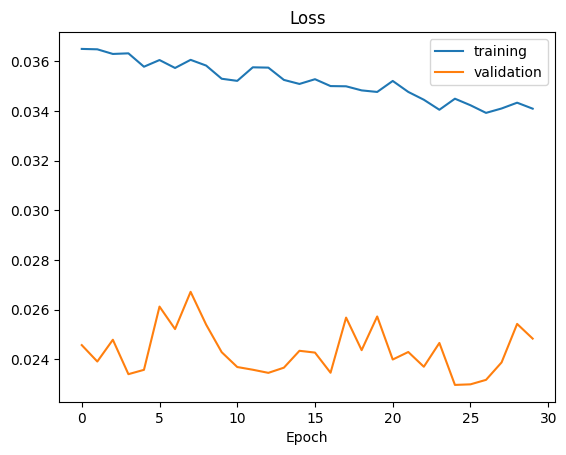

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.savefig(os.path.join("/content/drive/MyDrive/udacity_car_data/colab_run" , "Progess_graphs2.png"))
np.savez(os.path.join("/content/drive/MyDrive/udacity_car_data/colab_run" , "history.npz"))

In [30]:
model.save("colab2_100_mse.h5")
model.save(os.path.join("/content/drive/MyDrive/udacity_car_data/colab_run" , "colab2_100_mse.h5"))
from google.colab import files
files.download('colab2_100_mse.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>